In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/SoftCom/Dataset_2.zip"

Archive:  /content/drive/MyDrive/SoftCom/Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


In [5]:
train_csv  = pd.read_csv('/content/Dataset_2/verification_train.csv')
test_csv = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [6]:
import numpy as np
class second_Dataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [7]:
train_set = second_Dataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = second_Dataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [9]:
print(len(train_set))
print(len(test_set))

60000
10000


In [10]:
# Hyperparameters

batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)





class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 100 --> 100
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 100 --> 100
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_6 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_4(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_5(out)
        
        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_6(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss= []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration No: {}.\n Loss Value: {}.\n Accuracy Value: {}\n'.format(iter, loss.item(), accuracy))

Iteration No: 500.
 Loss Value: 0.6243300437927246.
 Accuracy Value: 80.18

Iteration No: 1000.
 Loss Value: 0.7441383004188538.
 Accuracy Value: 79.58

Iteration No: 1500.
 Loss Value: 0.21704360842704773.
 Accuracy Value: 83.62

Iteration No: 2000.
 Loss Value: 0.5760945081710815.
 Accuracy Value: 79.34

Iteration No: 2500.
 Loss Value: 0.31595778465270996.
 Accuracy Value: 79.93

Iteration No: 3000.
 Loss Value: 0.6680461764335632.
 Accuracy Value: 84.61

Iteration No: 3500.
 Loss Value: 0.3258109390735626.
 Accuracy Value: 85.07

Iteration No: 4000.
 Loss Value: 0.36457550525665283.
 Accuracy Value: 82.65

Iteration No: 4500.
 Loss Value: 0.12771601974964142.
 Accuracy Value: 85.43

Iteration No: 5000.
 Loss Value: 0.6910598874092102.
 Accuracy Value: 85.29

Iteration No: 5500.
 Loss Value: 0.3269910216331482.
 Accuracy Value: 86.43

Iteration No: 6000.
 Loss Value: 0.4367613196372986.
 Accuracy Value: 86.39

Iteration No: 6500.
 Loss Value: 0.6970871686935425.
 Accuracy Value: 85.

[0.6243300437927246, 0.7441383004188538, 0.21704360842704773, 0.5760945081710815, 0.31595778465270996, 0.6680461764335632, 0.3258109390735626, 0.36457550525665283, 0.12771601974964142, 0.6910598874092102, 0.3269910216331482, 0.4367613196372986, 0.6970871686935425, 0.34193894267082214, 0.2109731137752533, 0.7570395469665527, 0.12791487574577332, 0.3390199840068817, 0.47221535444259644, 0.22221429646015167, 0.4898499846458435, 0.23179805278778076, 0.3167209327220917, 0.4956270754337311, 0.09602589160203934, 0.3210437297821045, 0.164852112531662, 0.21026520431041718, 0.456233412027359, 0.24254348874092102, 0.13321518898010254, 0.42772799730300903, 0.4341885447502136, 0.22072961926460266, 0.235541433095932, 0.3149202764034271]


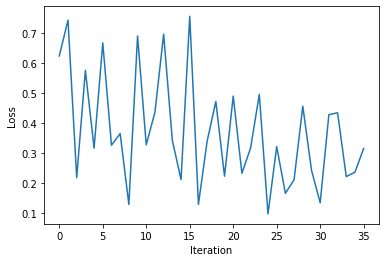

In [12]:
import matplotlib.pyplot as plt
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()